# Read Data Sample

In [20]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [1, 4, 16, 32, 64, 122]
    hidden_layers_arr = [1, 3, 5]
    
    epochs = [20]
    lrs = [1e-5, 1e-6, 1e-7]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:20 hidden layers:1 features count:1
Step 1 | Training Loss: 0.777004 | Validation Accuracy: 0.563582
Accuracy on Test data: 0.44144782423973083, 0.22092826664447784
Step 2 | Training Loss: 0.728217 | Validation Accuracy: 0.593269
Accuracy on Test data: 0.47901880741119385, 0.2433755248785019
Step 3 | Training Loss: 0.660577 | Validation Accuracy: 0.634386
Accuracy on Test data: 0.5603708028793335, 0.2653164565563202
Step 4 | Training Loss: 0.616754 | Validation Accuracy: 0.704477
Accuracy on Test data: 0.6015791296958923, 0.32877635955810547
Step 5 | Training Loss: 0.572547 | Validation Accuracy: 0.824178
Accuracy on Test data: 0.6676720976829529, 0.38472574949264526
Step 6 | Training Loss: 0.534059 | Validation Accuracy: 0.876568
Accuracy on Test data: 0.692689836025238, 0.42742615938186646
Step 7 | Training Loss: 0.519222 | Validation Accuracy: 0.903794
Accuracy on Test data: 0.7143807411193848, 0.4680168628692627
Step 8 | Training Loss: 0.489144 | V

Step 5 | Training Loss: 0.500190 | Validation Accuracy: 0.898873
Accuracy on Test data: 0.8661727905273438, 0.7550210952758789
Step 6 | Training Loss: 0.472174 | Validation Accuracy: 0.913081
Accuracy on Test data: 0.8595191836357117, 0.7410126328468323
Step 7 | Training Loss: 0.475786 | Validation Accuracy: 0.944118
Accuracy on Test data: 0.8691447973251343, 0.7586497664451599
Step 8 | Training Loss: 0.453214 | Validation Accuracy: 0.946738
Accuracy on Test data: 0.870120644569397, 0.7602531909942627
Step 9 | Training Loss: 0.446380 | Validation Accuracy: 0.949278
Accuracy on Test data: 0.8694552779197693, 0.7589873671531677
Step 10 | Training Loss: 0.420007 | Validation Accuracy: 0.949992
Accuracy on Test data: 0.8685681223869324, 0.7568776607513428
Step 11 | Training Loss: 0.419335 | Validation Accuracy: 0.952215
Accuracy on Test data: 0.8667938113212585, 0.753248929977417
Step 12 | Training Loss: 0.410896 | Validation Accuracy: 0.954040
Accuracy on Test data: 0.8648420572280884, 0.

Step 9 | Training Loss: 0.428129 | Validation Accuracy: 0.948960
Accuracy on Test data: 0.7372693419456482, 0.502869188785553
Step 10 | Training Loss: 0.429529 | Validation Accuracy: 0.958168
Accuracy on Test data: 0.7429915070533752, 0.5137552618980408
Step 11 | Training Loss: 0.412351 | Validation Accuracy: 0.963089
Accuracy on Test data: 0.7476934194564819, 0.5227004289627075
Step 12 | Training Loss: 0.398463 | Validation Accuracy: 0.961581
Accuracy on Test data: 0.7481813430786133, 0.5237130522727966
Step 13 | Training Loss: 0.399832 | Validation Accuracy: 0.968011
Accuracy on Test data: 0.7481369972229004, 0.5236287117004395
Step 14 | Training Loss: 0.384146 | Validation Accuracy: 0.965709
Accuracy on Test data: 0.7481813430786133, 0.5237130522727966
Step 15 | Training Loss: 0.386666 | Validation Accuracy: 0.965312
Accuracy on Test data: 0.747427225112915, 0.5222784876823425
Step 16 | Training Loss: 0.376054 | Validation Accuracy: 0.968725
Accuracy on Test data: 0.7465400695800781

Step 13 | Training Loss: 0.402723 | Validation Accuracy: 0.964280
Accuracy on Test data: 0.817689836025238, 0.654599130153656
Step 14 | Training Loss: 0.392659 | Validation Accuracy: 0.965074
Accuracy on Test data: 0.8138307332992554, 0.647257387638092
Step 15 | Training Loss: 0.374696 | Validation Accuracy: 0.965233
Accuracy on Test data: 0.7925834059715271, 0.6068354249000549
Step 16 | Training Loss: 0.365829 | Validation Accuracy: 0.967376
Accuracy on Test data: 0.7843772172927856, 0.5911392569541931
Step 17 | Training Loss: 0.378761 | Validation Accuracy: 0.969440
Accuracy on Test data: 0.7826915979385376, 0.5878481268882751
Step 18 | Training Loss: 0.362303 | Validation Accuracy: 0.968090
Accuracy on Test data: 0.7811834812164307, 0.5849788784980774
Step 19 | Training Loss: 0.362318 | Validation Accuracy: 0.971424
Accuracy on Test data: 0.7806955575942993, 0.5839662551879883
Step 20 | Training Loss: 0.366252 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.779675304889679,

Step 17 | Training Loss: 0.379719 | Validation Accuracy: 0.966344
Accuracy on Test data: 0.7680979371070862, 0.5602531433105469
Step 18 | Training Loss: 0.369693 | Validation Accuracy: 0.964994
Accuracy on Test data: 0.7674769163131714, 0.5589873194694519
Step 19 | Training Loss: 0.366651 | Validation Accuracy: 0.970710
Accuracy on Test data: 0.7662792801856995, 0.5566244721412659
Step 20 | Training Loss: 0.370362 | Validation Accuracy: 0.969043
Accuracy on Test data: 0.765835702419281, 0.5557805895805359
Step 1 | Training Loss: 0.359450 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.7655695676803589, 0.555274248123169
Step 2 | Training Loss: 0.374335 | Validation Accuracy: 0.971027
Accuracy on Test data: 0.7653477787971497, 0.554852306842804
Step 3 | Training Loss: 0.360776 | Validation Accuracy: 0.968328
Accuracy on Test data: 0.7652146816253662, 0.5545991659164429
Step 4 | Training Loss: 0.365722 | Validation Accuracy: 0.966344
Accuracy on Test data: 0.7651259899139404, 0.

Step 1 | Training Loss: 0.366589 | Validation Accuracy: 0.968328
Accuracy on Test data: 0.7542139887809753, 0.5340084433555603
Step 2 | Training Loss: 0.380237 | Validation Accuracy: 0.967693
Accuracy on Test data: 0.7539921998977661, 0.5335021018981934
Step 3 | Training Loss: 0.370951 | Validation Accuracy: 0.969043
Accuracy on Test data: 0.7539478540420532, 0.5334177017211914
Step 4 | Training Loss: 0.375410 | Validation Accuracy: 0.970233
Accuracy on Test data: 0.7538591027259827, 0.5332489609718323
Step 5 | Training Loss: 0.375739 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7537704110145569, 0.5330801606178284
Step 6 | Training Loss: 0.381182 | Validation Accuracy: 0.970233
Accuracy on Test data: 0.7535486221313477, 0.5326582193374634
Step 7 | Training Loss: 0.372525 | Validation Accuracy: 0.968011
Accuracy on Test data: 0.7536816596984863, 0.5328270196914673
Step 8 | Training Loss: 0.374072 | Validation Accuracy: 0.967931
Accuracy on Test data: 0.7535929679870605, 0.5

Step 5 | Training Loss: 0.657520 | Validation Accuracy: 0.924671
Accuracy on Test data: 0.753726065158844, 0.5342615842819214
Step 6 | Training Loss: 0.655300 | Validation Accuracy: 0.929433
Accuracy on Test data: 0.754036545753479, 0.5348523259162903
Step 7 | Training Loss: 0.646328 | Validation Accuracy: 0.929592
Accuracy on Test data: 0.7543026804924011, 0.5353586673736572
Step 8 | Training Loss: 0.658532 | Validation Accuracy: 0.927925
Accuracy on Test data: 0.7546132206916809, 0.5359493494033813
Step 9 | Training Loss: 0.654409 | Validation Accuracy: 0.924432
Accuracy on Test data: 0.7547906041145325, 0.5362868905067444
Step 10 | Training Loss: 0.658692 | Validation Accuracy: 0.928004
Accuracy on Test data: 0.754879355430603, 0.5364556908607483
Step 11 | Training Loss: 0.650710 | Validation Accuracy: 0.929513
Accuracy on Test data: 0.7551011443138123, 0.5368776321411133
Step 12 | Training Loss: 0.654212 | Validation Accuracy: 0.929354
Accuracy on Test data: 0.7550567984580994, 0.5

Step 9 | Training Loss: 0.621199 | Validation Accuracy: 0.954755
Accuracy on Test data: 0.7590045928955078, 0.548607587814331
Step 10 | Training Loss: 0.608296 | Validation Accuracy: 0.953088
Accuracy on Test data: 0.7591820359230042, 0.548776388168335
Step 11 | Training Loss: 0.609780 | Validation Accuracy: 0.957771
Accuracy on Test data: 0.7594038248062134, 0.5491983294487
Step 12 | Training Loss: 0.598368 | Validation Accuracy: 0.954596
Accuracy on Test data: 0.7595369219779968, 0.5493670701980591
Step 13 | Training Loss: 0.616361 | Validation Accuracy: 0.951818
Accuracy on Test data: 0.7597143650054932, 0.549535870552063
Step 14 | Training Loss: 0.618529 | Validation Accuracy: 0.957692
Accuracy on Test data: 0.759758710861206, 0.5496202707290649
Step 15 | Training Loss: 0.603730 | Validation Accuracy: 0.952453
Accuracy on Test data: 0.759803056716919, 0.5497046709060669
Step 16 | Training Loss: 0.622472 | Validation Accuracy: 0.955310
Accuracy on Test data: 0.7600691914558411, 0.55

Step 13 | Training Loss: 0.480520 | Validation Accuracy: 0.955390
Accuracy on Test data: 0.821415901184082, 0.6645569801330566
Step 14 | Training Loss: 0.478253 | Validation Accuracy: 0.955152
Accuracy on Test data: 0.8211941123008728, 0.6641350388526917
Step 15 | Training Loss: 0.489915 | Validation Accuracy: 0.957771
Accuracy on Test data: 0.8209723234176636, 0.6636286973953247
Step 16 | Training Loss: 0.469420 | Validation Accuracy: 0.953802
Accuracy on Test data: 0.8201295137405396, 0.6620253324508667
Step 17 | Training Loss: 0.457451 | Validation Accuracy: 0.956660
Accuracy on Test data: 0.8192423582077026, 0.6603375673294067
Step 18 | Training Loss: 0.474396 | Validation Accuracy: 0.954358
Accuracy on Test data: 0.8187544345855713, 0.6594092845916748
Step 19 | Training Loss: 0.477576 | Validation Accuracy: 0.952056
Accuracy on Test data: 0.8183108568191528, 0.6584810018539429
Step 20 | Training Loss: 0.469578 | Validation Accuracy: 0.959914
Accuracy on Test data: 0.81795597076416

Step 17 | Training Loss: 0.432100 | Validation Accuracy: 0.962772
Accuracy on Test data: 0.7803406715393066, 0.5859915614128113
Step 18 | Training Loss: 0.424720 | Validation Accuracy: 0.964836
Accuracy on Test data: 0.7801188826560974, 0.5855696201324463
Step 19 | Training Loss: 0.427350 | Validation Accuracy: 0.959835
Accuracy on Test data: 0.779675304889679, 0.5847257375717163
Step 20 | Training Loss: 0.426072 | Validation Accuracy: 0.964518
Accuracy on Test data: 0.7794535160064697, 0.5842193961143494
Step 1 | Training Loss: 0.421677 | Validation Accuracy: 0.960946
Accuracy on Test data: 0.7794535160064697, 0.5842193961143494
Step 2 | Training Loss: 0.422438 | Validation Accuracy: 0.960867
Accuracy on Test data: 0.7792760729789734, 0.5838818550109863
Step 3 | Training Loss: 0.428208 | Validation Accuracy: 0.961978
Accuracy on Test data: 0.7791873812675476, 0.5837130546569824
Step 4 | Training Loss: 0.426361 | Validation Accuracy: 0.964439
Accuracy on Test data: 0.7791873812675476, 

Step 1 | Training Loss: 0.382039 | Validation Accuracy: 0.960391
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 2 | Training Loss: 0.378744 | Validation Accuracy: 0.962931
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 3 | Training Loss: 0.381959 | Validation Accuracy: 0.960629
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 4 | Training Loss: 0.379745 | Validation Accuracy: 0.959994
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 5 | Training Loss: 0.382799 | Validation Accuracy: 0.962931
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 6 | Training Loss: 0.369070 | Validation Accuracy: 0.962057
Accuracy on Test data: 0.808463454246521, 0.6383966207504272
Step 7 | Training Loss: 0.399125 | Validation Accuracy: 0.963089
Accuracy on Test data: 0.8084191083908081, 0.6383122205734253
Step 8 | Training Loss: 0.363575 | Validation Accuracy: 0.961740
Accuracy on Test data: 0.8084191083908081, 0.6383122

Step 5 | Training Loss: 0.364052 | Validation Accuracy: 0.961978
Accuracy on Test data: 0.8093506097793579, 0.6394936442375183
Step 6 | Training Loss: 0.359439 | Validation Accuracy: 0.961184
Accuracy on Test data: 0.8092175126075745, 0.6392405033111572
Step 7 | Training Loss: 0.385892 | Validation Accuracy: 0.963328
Accuracy on Test data: 0.8091731667518616, 0.6391561031341553
Step 8 | Training Loss: 0.345344 | Validation Accuracy: 0.964121
Accuracy on Test data: 0.8092175126075745, 0.6392405033111572
Step 9 | Training Loss: 0.360304 | Validation Accuracy: 0.963486
Accuracy on Test data: 0.8091731667518616, 0.6391561031341553
Step 10 | Training Loss: 0.371345 | Validation Accuracy: 0.962613
Accuracy on Test data: 0.8091288208961487, 0.6390717029571533
Step 11 | Training Loss: 0.384581 | Validation Accuracy: 0.964201
Accuracy on Test data: 0.8091731667518616, 0.6391561031341553
Step 12 | Training Loss: 0.365151 | Validation Accuracy: 0.962613
Accuracy on Test data: 0.8091288208961487, 

Step 8 | Training Loss: 0.691445 | Validation Accuracy: 0.535720
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.692743 | Validation Accuracy: 0.536196
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 0.692248 | Validation Accuracy: 0.534688
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 11 | Training Loss: 0.691939 | Validation Accuracy: 0.534371
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 12 | Training Loss: 0.693177 | Validation Accuracy: 0.535323
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 13 | Training Loss: 0.692124 | Validation Accuracy: 0.537466
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 14 | Training Loss: 0.692867 | Validation Accuracy: 0.533974
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 15 | Training Loss: 0.691255 | Validation Accuracy: 0.535402
Accuracy on Test data: 0.4

Step 12 | Training Loss: 0.644326 | Validation Accuracy: 0.941181
Accuracy on Test data: 0.8637775182723999, 0.7477636933326721
Step 13 | Training Loss: 0.652975 | Validation Accuracy: 0.942531
Accuracy on Test data: 0.863733172416687, 0.7476793527603149
Step 14 | Training Loss: 0.647514 | Validation Accuracy: 0.946738
Accuracy on Test data: 0.863733172416687, 0.7476793527603149
Step 15 | Training Loss: 0.654443 | Validation Accuracy: 0.945864
Accuracy on Test data: 0.863733172416687, 0.7476793527603149
Step 16 | Training Loss: 0.642780 | Validation Accuracy: 0.948166
Accuracy on Test data: 0.8636887669563293, 0.747594952583313
Step 17 | Training Loss: 0.649232 | Validation Accuracy: 0.948166
Accuracy on Test data: 0.8636887669563293, 0.747594952583313
Step 18 | Training Loss: 0.652166 | Validation Accuracy: 0.947134
Accuracy on Test data: 0.8637775182723999, 0.7476793527603149
Step 19 | Training Loss: 0.652762 | Validation Accuracy: 0.948722
Accuracy on Test data: 0.8637775182723999, 

Step 16 | Training Loss: 0.655655 | Validation Accuracy: 0.912526
Accuracy on Test data: 0.7523509860038757, 0.5388185381889343
Step 17 | Training Loss: 0.654967 | Validation Accuracy: 0.913637
Accuracy on Test data: 0.7523509860038757, 0.5388185381889343
Step 18 | Training Loss: 0.652377 | Validation Accuracy: 0.911018
Accuracy on Test data: 0.7523065805435181, 0.5387341976165771
Step 19 | Training Loss: 0.622419 | Validation Accuracy: 0.910700
Accuracy on Test data: 0.7523509860038757, 0.5388185381889343
Step 20 | Training Loss: 0.641479 | Validation Accuracy: 0.912923
Accuracy on Test data: 0.7523953318595886, 0.5389029383659363
Current Layer Attributes - epochs:20 hidden layers:5 features count:32
Step 1 | Training Loss: 0.740122 | Validation Accuracy: 0.542467
Accuracy on Test data: 0.4309350550174713, 0.1817721575498581
Step 2 | Training Loss: 0.746009 | Validation Accuracy: 0.538816
Accuracy on Test data: 0.43204399943351746, 0.1833755224943161
Step 3 | Training Loss: 0.743248 |

Step 20 | Training Loss: 0.524212 | Validation Accuracy: 0.944515
Accuracy on Test data: 0.808773934841156, 0.6399155855178833
Current Layer Attributes - epochs:20 hidden layers:5 features count:64
Step 1 | Training Loss: 0.712067 | Validation Accuracy: 0.560010
Accuracy on Test data: 0.43674591183662415, 0.19248944520950317
Step 2 | Training Loss: 0.722781 | Validation Accuracy: 0.623035
Accuracy on Test data: 0.5243080258369446, 0.3532489538192749
Step 3 | Training Loss: 0.710759 | Validation Accuracy: 0.810367
Accuracy on Test data: 0.7234740853309631, 0.4935865104198456
Step 4 | Training Loss: 0.698079 | Validation Accuracy: 0.856565
Accuracy on Test data: 0.7674325704574585, 0.5732489228248596
Step 5 | Training Loss: 0.664673 | Validation Accuracy: 0.901334
Accuracy on Test data: 0.788591206073761, 0.6124050617218018
Step 6 | Training Loss: 0.659139 | Validation Accuracy: 0.908716
Accuracy on Test data: 0.7970635294914246, 0.6264978647232056
Step 7 | Training Loss: 0.641198 | Vali

Step 4 | Training Loss: 0.652509 | Validation Accuracy: 0.896968
Accuracy on Test data: 0.845635175704956, 0.7240506410598755
Step 5 | Training Loss: 0.625383 | Validation Accuracy: 0.917685
Accuracy on Test data: 0.8328601717948914, 0.6937552690505981
Step 6 | Training Loss: 0.596021 | Validation Accuracy: 0.936895
Accuracy on Test data: 0.8200408220291138, 0.6662447452545166
Step 7 | Training Loss: 0.556349 | Validation Accuracy: 0.944912
Accuracy on Test data: 0.8211497664451599, 0.6654852032661438
Step 8 | Training Loss: 0.512167 | Validation Accuracy: 0.952453
Accuracy on Test data: 0.8270936608314514, 0.6751898527145386
Step 9 | Training Loss: 0.470324 | Validation Accuracy: 0.955469
Accuracy on Test data: 0.8249201774597168, 0.6708016991615295
Step 10 | Training Loss: 0.466229 | Validation Accuracy: 0.955866
Accuracy on Test data: 0.8233232498168945, 0.6676793098449707
Step 11 | Training Loss: 0.432817 | Validation Accuracy: 0.958327
Accuracy on Test data: 0.8231902122497559, 0.

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
167,8,4,5,0.897127,0.876863,0.776287,12.011190
159,7,122,3,0.915780,0.866528,0.758565,14.312281
140,13,16,3,0.933323,0.862535,0.747257,18.839120
32,6,32,1,0.915780,0.851623,0.728945,5.653030
153,9,64,3,0.937768,0.850692,0.719747,15.541927
93,63,1,3,0.929830,0.756875,0.540253,75.135141


In [14]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score_20'].transform(max) == df_results['test_score_20']
df_results[idx].sort_values(by = 'test_score_20', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
165,6,4,5,0.879902,0.874778,0.777046,8.578906
236,4,122,5,0.814891,0.859652,0.771392,10.434872
140,13,16,3,0.933323,0.862535,0.747257,18.839120
32,6,32,1,0.915780,0.851623,0.728945,5.653030
153,9,64,3,0.937768,0.850692,0.719747,15.541927
93,63,1,3,0.929830,0.756875,0.540253,75.135141


In [21]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
167,8,4,5,0.897127,0.876863,0.776287,12.011190
166,7,4,5,0.889189,0.875843,0.776034,10.298957
165,6,4,5,0.879902,0.874778,0.777046,8.578906
164,5,4,5,0.878314,0.871407,0.775612,6.874862
17,9,4,1,0.946738,0.870121,0.760253,9.030899
163,4,4,5,0.874583,0.869855,0.774684,5.171532
16,8,4,1,0.944118,0.869145,0.758650,7.906469
159,7,122,3,0.915780,0.866528,0.758565,14.312281
15,6,4,1,0.898873,0.866173,0.755021,5.743569
14,5,4,1,0.885299,0.865729,0.756371,4.627712


In [16]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9067  0.0933]
 [ 0.1457  0.8543]]


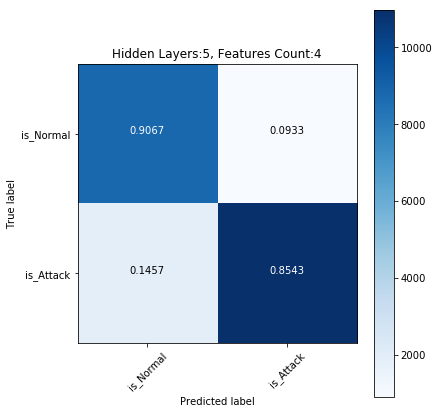

In [18]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.6366  0.3634]
 [ 0.1927  0.8073]]


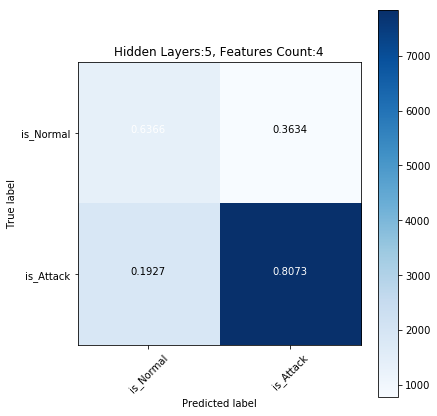

In [19]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)